# Loading the librairies

In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
import calplot
import adtk.visualization as viz
from adtk.detector import GeneralizedESDTestAD, PersistAD
from adtk.data import validate_series
import warnings
warnings.filterwarnings('ignore')

# Preparing the data

In [21]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [2]:
customers_df = pd.read_excel('../data/CUSTOMERS.XLSX')
employees_df = pd.read_excel('../data/EMPLOYEES.XLSX')
items_df = pd.read_excel('../data/ITEMS.XLSX')
order_details_df = pd.read_excel('../data/ORDERINFO.XLSX')
orders_df = pd.read_excel('../data/ORDERS.XLSX')

# Orders DataFrame overview

## Description

In [3]:
orders_df.describe()

,Order No,Customer ID,Employee Code,Order Date,Dispatch Date,total
count,149425.000000,149425.000000,149425.000000,149425,149425,149425.000000
mean,74781.437223,4001.346575,100.092474,2013-01-02 12:41:22.572528128,2013-01-13 11:13:29.816295680,52.802344
min,1.000000,1.000000,1.000000,2010-02-22 00:00:00,2010-02-22 00:00:00,19.000000
25%,37358.000000,2018.000000,50.000000,2011-07-29 00:00:00,2011-08-09 00:00:00,34.430000
50%,74714.000000,3996.000000,100.000000,2013-01-02 00:00:00,2013-01-14 00:00:00,49.280000
75%,112070.000000,5995.000000,150.000000,2014-06-06 00:00:00,2014-06-18 00:00:00,64.490000
max,150000.000000,8000.000000,200.000000,2015-11-24 00:00:00,2015-12-14 00:00:00,274.430000
std,43238.759487,2303.209772,58.114861,NaN,NaN,29.040029


## Sales per order distribution

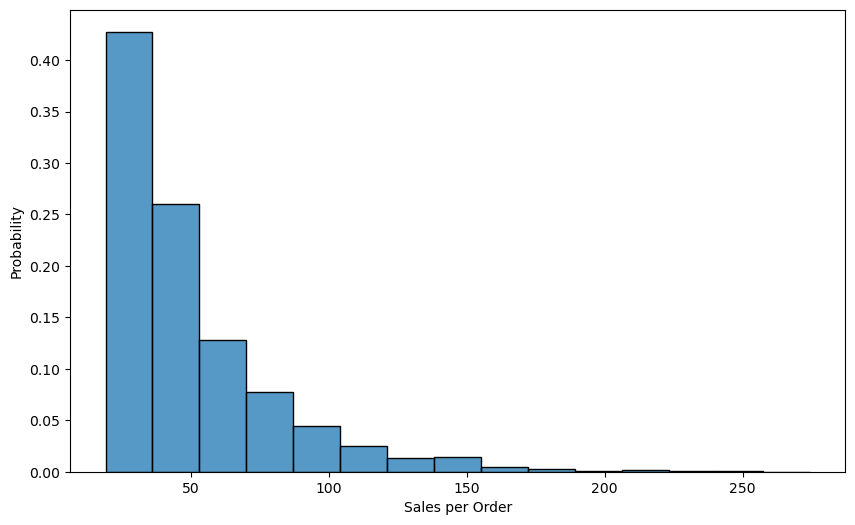

In [431]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=orders_df, x="total", bins=15, stat = "probability", kde=False)
ax.set(xlabel='Sales per Order', ylabel='Probability');

# Yearly sales analysis

In [399]:
def order_size(oid):
    return len(order_details_df[order_details_df['Order No'] == oid])

In [400]:
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'])
orders_df['month'] = orders_df['Order Date'].dt.month
orders_df['year'] = orders_df['Order Date'].dt.year
orders_df['day'] = orders_df['Order Date'].dt.day
orders_df['size'] = orders_df['Order No'].apply(order_size)

In [394]:
yearly_orders_df = orders_df.groupby(['year']).agg({'total': 'sum'}).reset_index()
yearly_orders_df['count'] = orders_df.groupby(['year']).agg({'total': 'count'}).reset_index()['total']

## Total sales per year

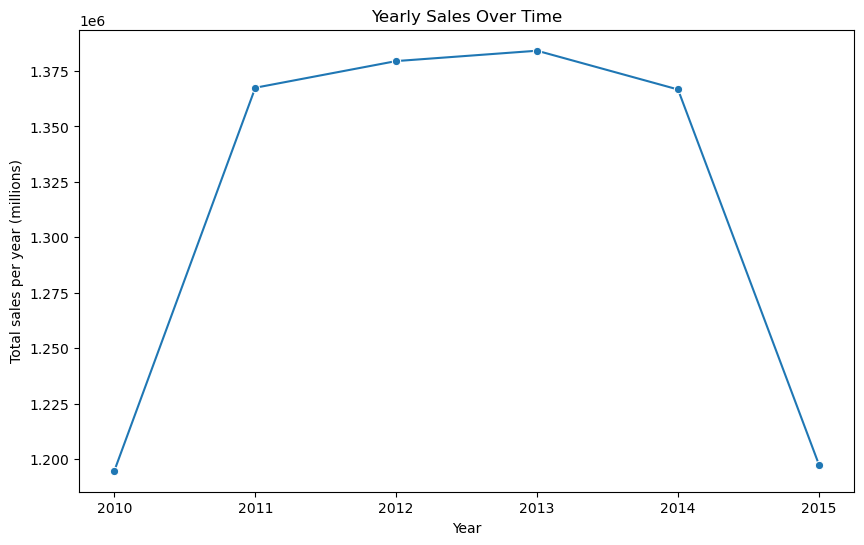

In [430]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(yearly_orders_df, x='year', y='total', marker='o', linestyle='-');
ax.set(xlabel='Year', ylabel='Total sales per year (millions)', title='Yearly Sales Over Time');

## Order price boxplot

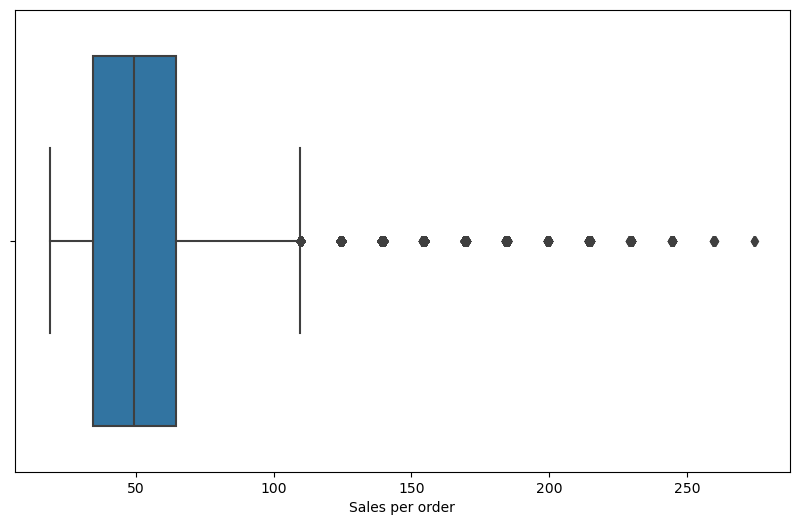

In [656]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=orders_df, x='total')
ax.set(xlabel='Sales per order');

## Some key plots

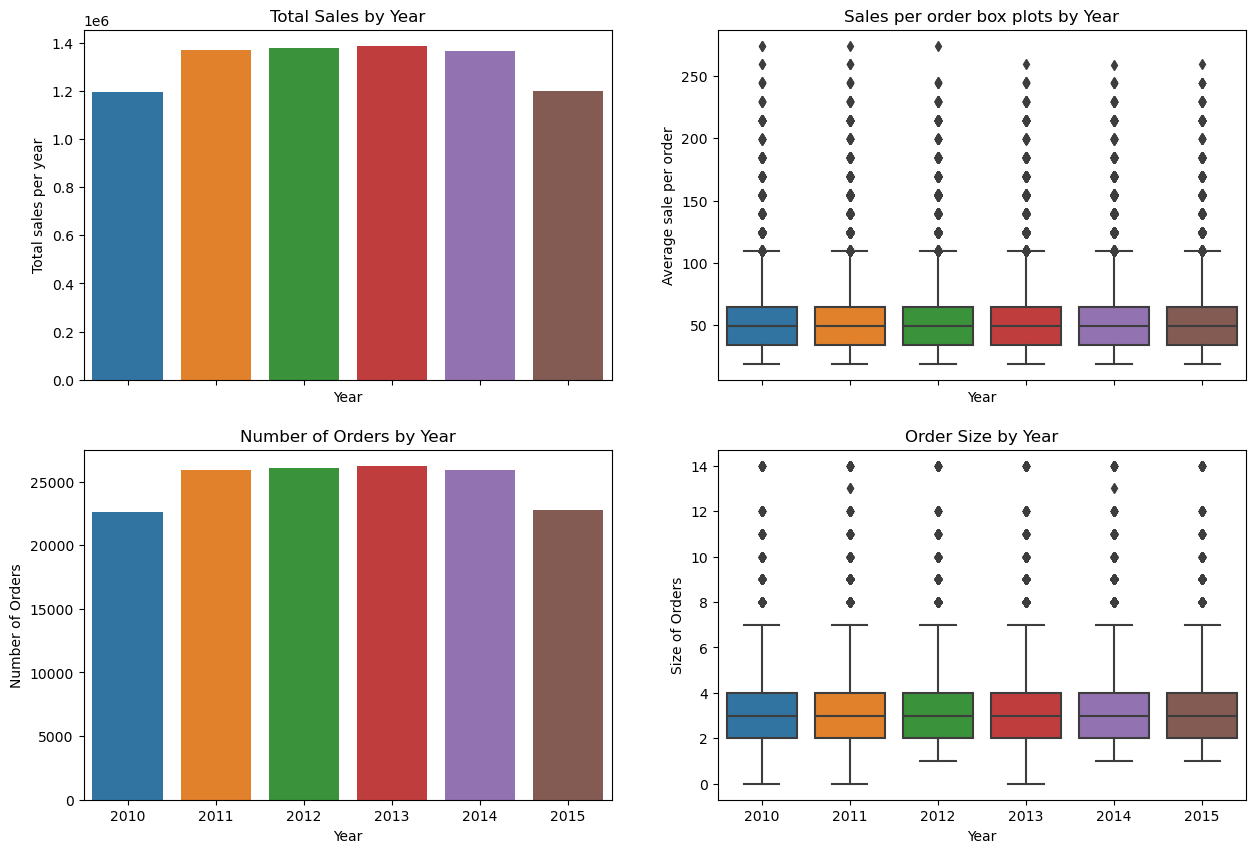

In [429]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

sns.barplot(ax=axs[0, 0], data=yearly_orders_df, x='year', y='total')
sns.boxplot(ax=axs[0, 1], data=orders_df, y="total", x='year')
# sns.stripplot(ax=axs[0, 1], data=orders_df, y="total", x='year')

sns.boxplot(ax=axs[1, 1], data=orders_df, y="size", x='year')
sns.barplot(ax=axs[1, 0], data=yearly_orders_df, x="year", y="count")

axs[0, 0].set(xlabel='Year', ylabel='Total sales per year', title='Total Sales by Year');
axs[0, 1].set(xlabel='Year', ylabel='Average sale per order', title='Sales per order box plots by Year');
axs[1, 1].set(xlabel='Year', ylabel='Size of Orders', title='Order Size by Year');
axs[1, 0].set(xlabel='Year', ylabel='Number of Orders', title='Number of Orders by Year');

# Monthly sales analysis

In [8]:
monthly_orders_df = orders_df.groupby(['year', 'month']).agg({'total': 'sum'}).reset_index()
monthly_orders_df['date'] = pd.to_datetime(monthly_orders_df[['year', 'month']].assign(day=1))
monthly_orders_df = monthly_orders_df.sort_values('date')

## Total sales each month 

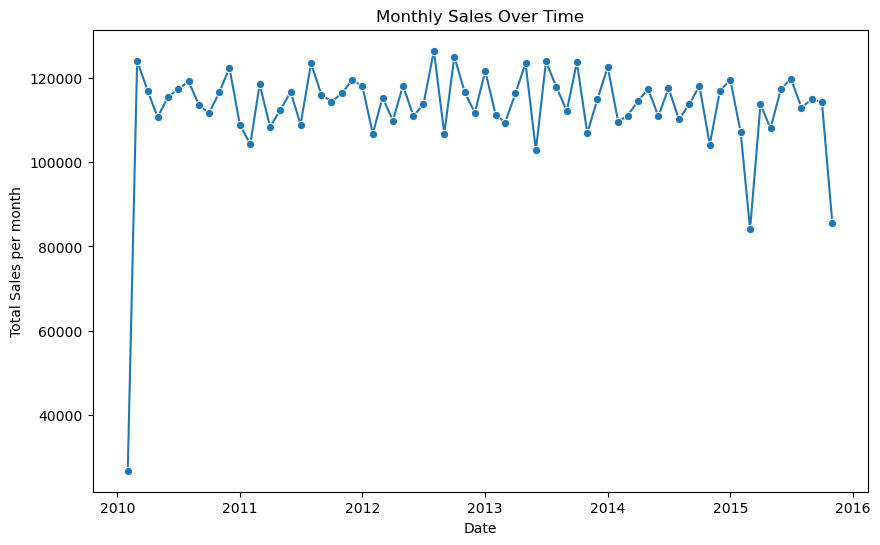

In [432]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(monthly_orders_df, x='date', y='total', marker='o', linestyle='-')
ax.set(title='Monthly Sales Over Time', xlabel='Date', ylabel='Total Sales per month');

## Sales per month + Confidence interval

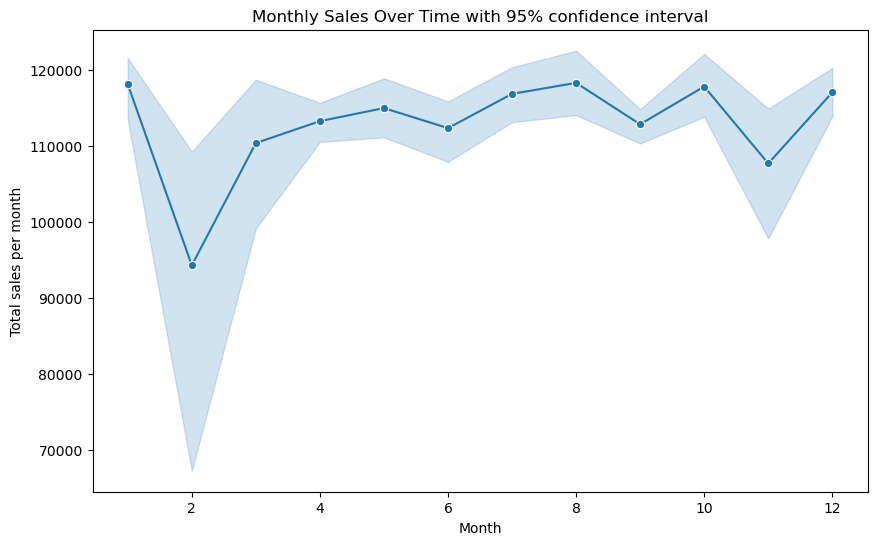

In [433]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(monthly_orders_df, x='month', y='total', marker='o')
ax.set(xlabel='Month', ylabel='Total sales per month', title='Monthly Sales Over Time with 95% confidence interval');

## Some key plots

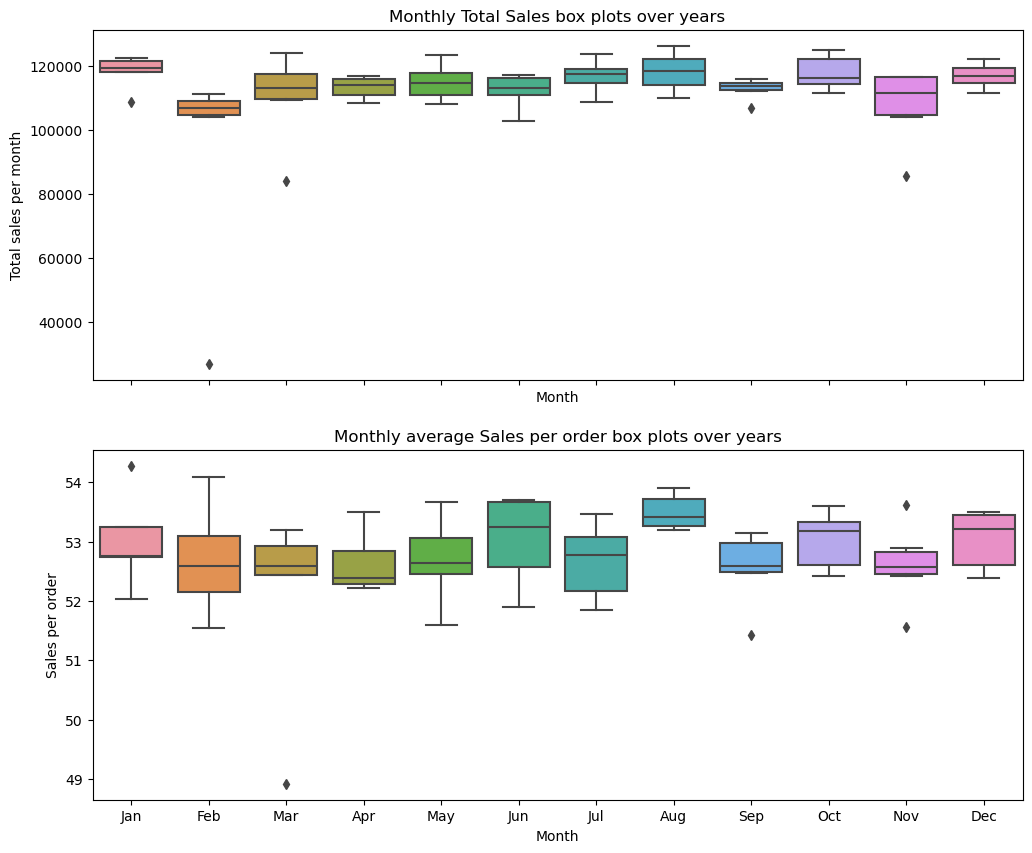

In [434]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.boxplot(ax=axs[0], data=orders_df.groupby(['year', 'month']).agg({'total': 'sum'}).reset_index(), y="total", x='month')

sns.boxplot(ax=axs[1], data=orders_df.groupby(['year', 'month']).agg({'total': 'mean'}).reset_index(), y="total", x='month')

axs[0].set(xlabel='Month', ylabel='Total sales per month', title='Monthly Total Sales box plots over years');
axs[1].set(xlabel='Month', ylabel='Sales per order', title='Monthly average Sales per order box plots over years', xticklabels=months);

# Daily sales analysis

In [15]:
daily_orders_df = orders_df.groupby(['year', 'month','day']).agg({'total':'sum'}).reset_index()
daily_orders_df['date'] = pd.to_datetime(daily_orders_df[['year', 'month', 'day']])

## Daily sales plot

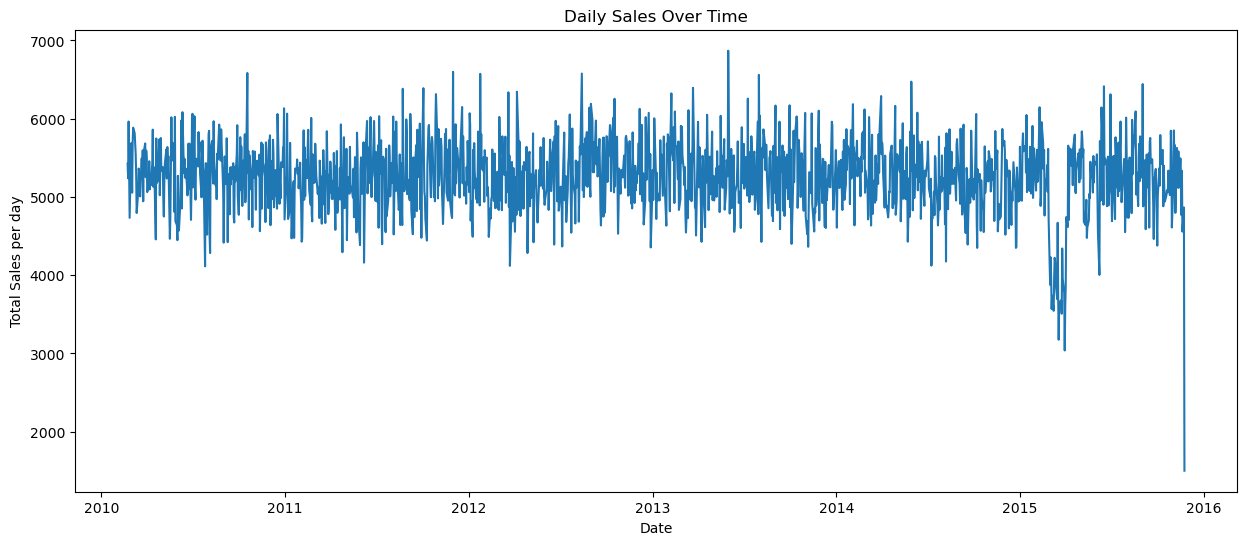

In [443]:
plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=daily_orders_df, x='date', y='total', linestyle='-')
ax.set(title='Daily Sales Over Time', xlabel='Date', ylabel='Total Sales per day');

## Daily sales + Confidence interval

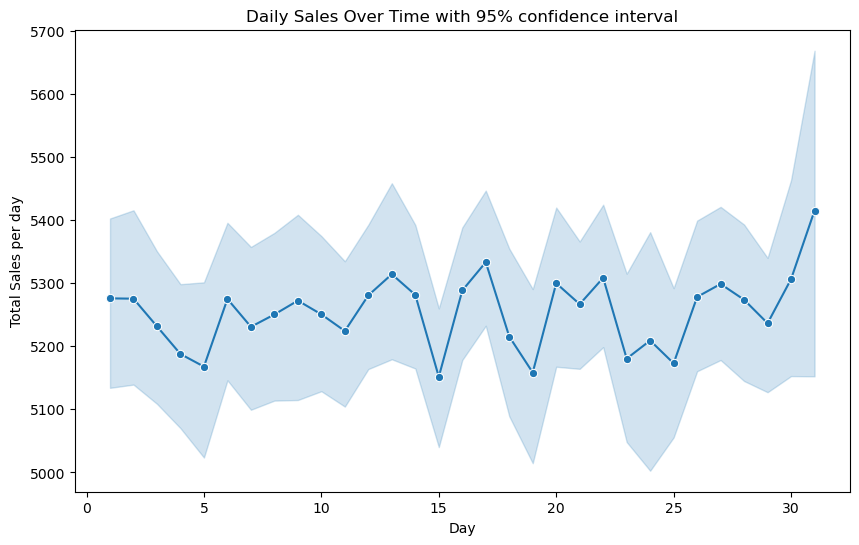

In [442]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(daily_orders_df, x='day', y='total', marker='o', linestyle='-');
ax.set(ylabel='Total Sales per day', xlabel='Day', title='Daily Sales Over Time with 95% confidence interval');

## Sales per day variations

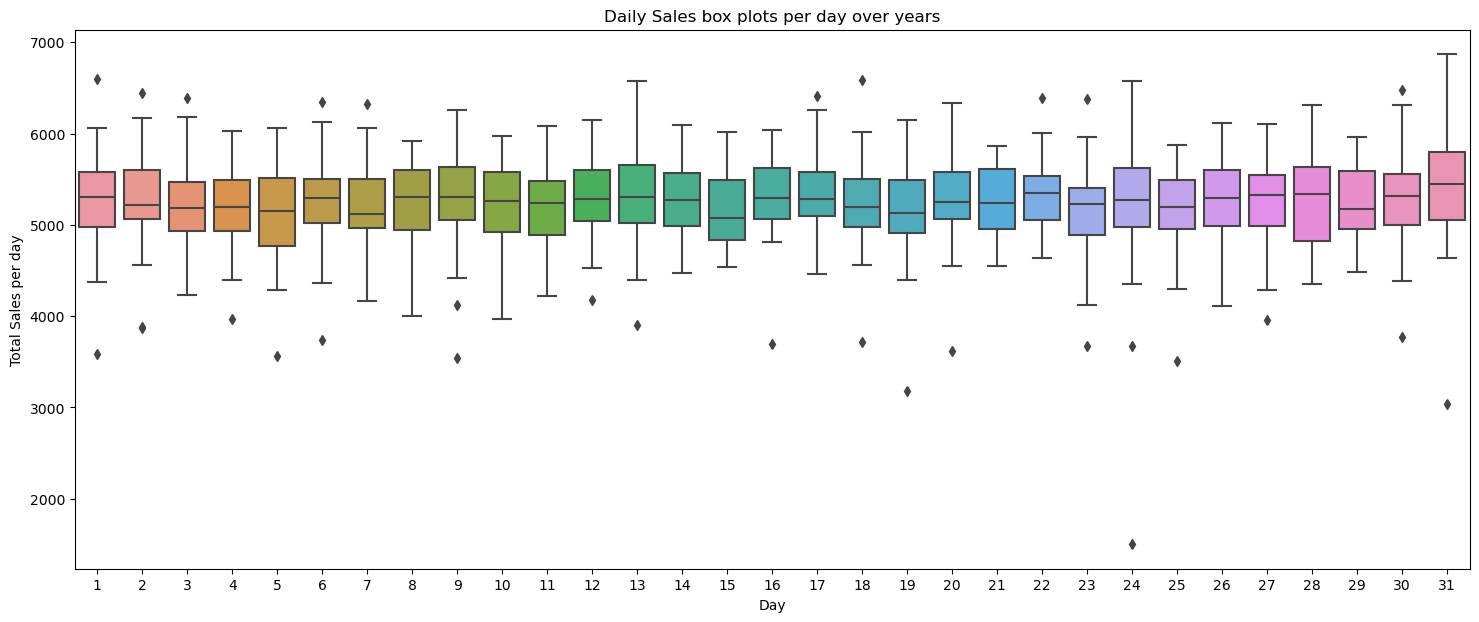

In [445]:
plt.figure(figsize=(18, 7))
ax = sns.boxplot(data=daily_orders_df, y="total", x='day');
ax.set(ylabel='Total Sales per day', xlabel='Day', title='Daily Sales box plots per day over years');

## Daily sales heatmap

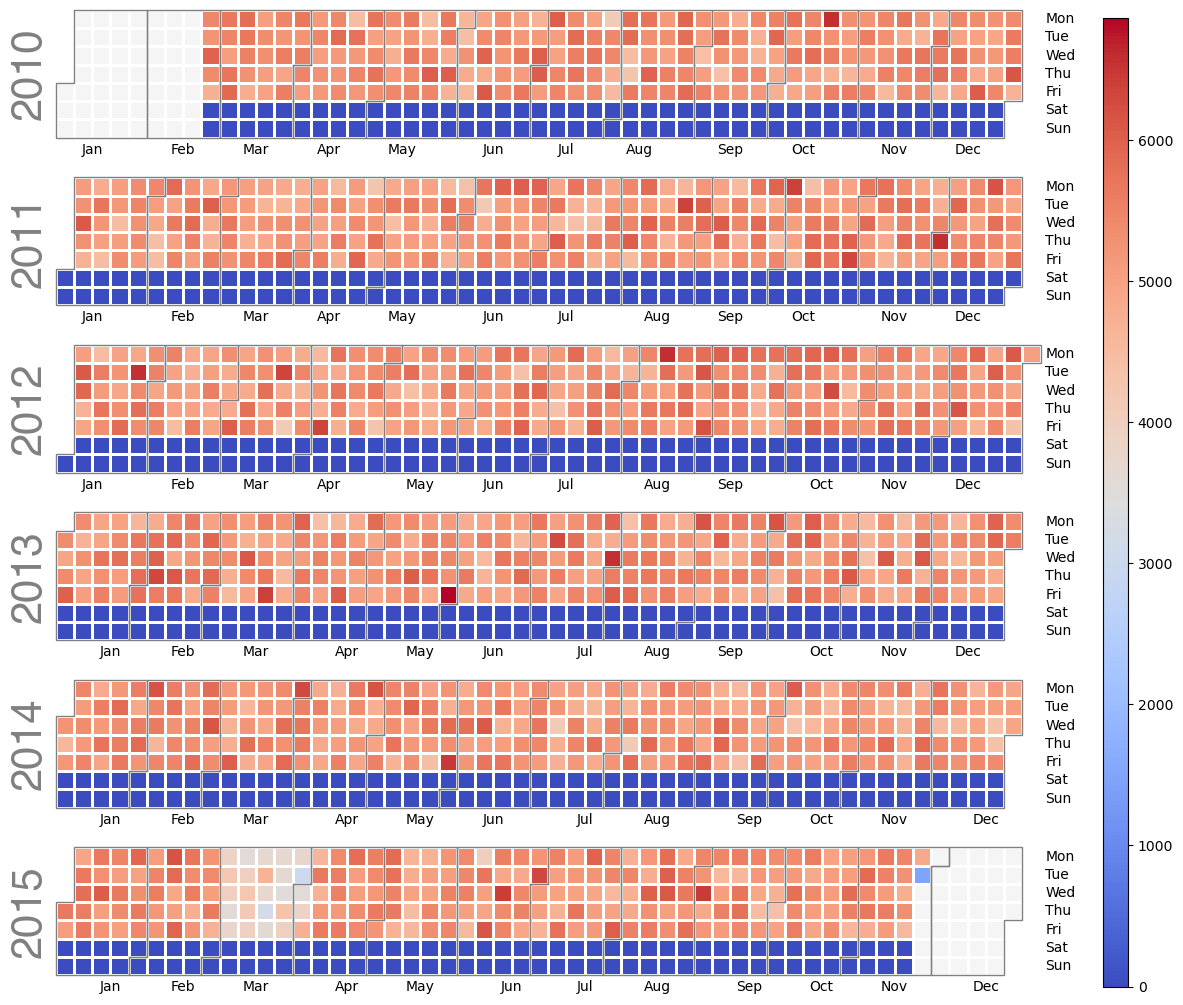

In [495]:
heatmap_df = daily_orders_df[['total', 'date']]
heatmap_df['date'] = pd.to_datetime(heatmap_df['date'])
heatmap_df.set_index('date', inplace=True)
calplot.calplot(heatmap_df['total'], cmap="coolwarm", colorbar=True);

## Daily sales + Moving Average

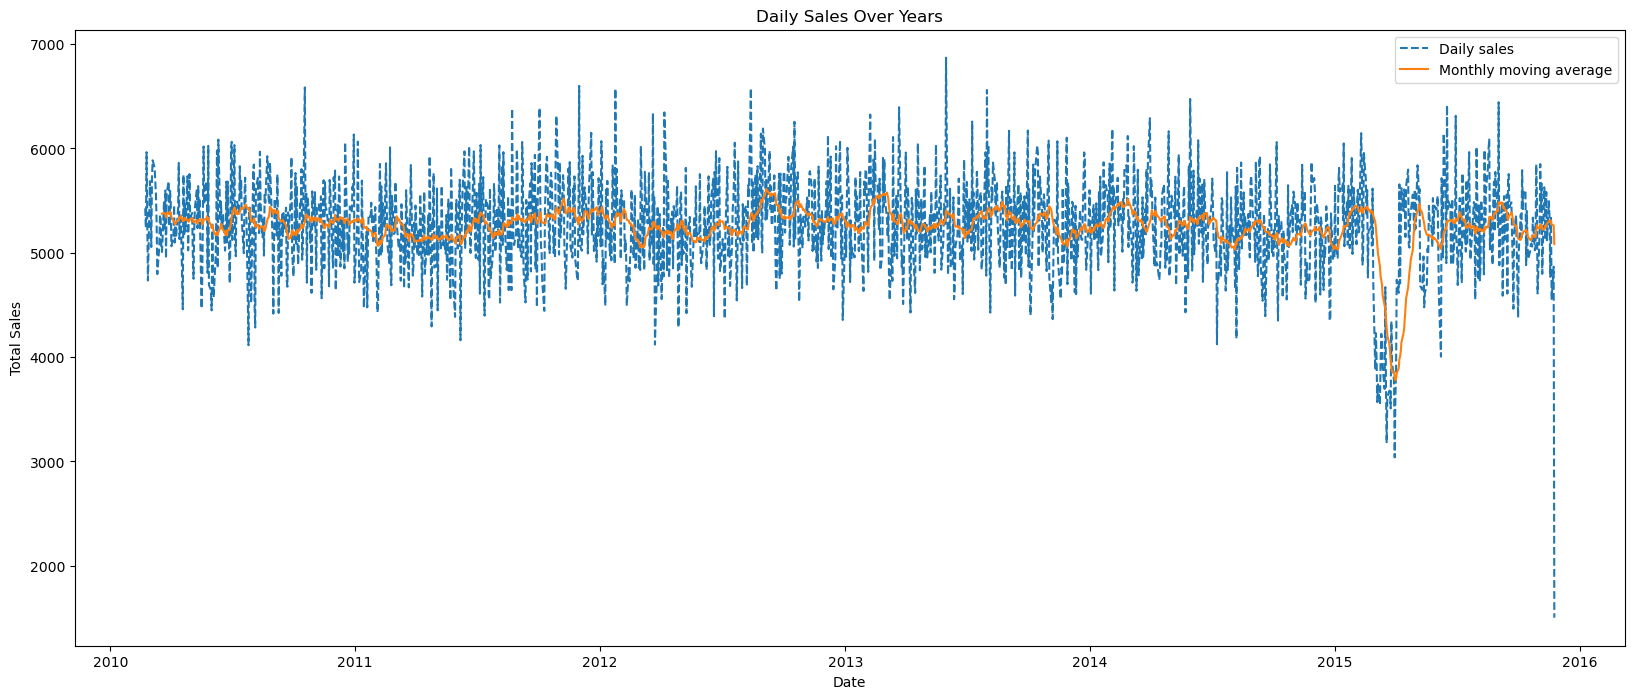

In [458]:
plt.figure(figsize=(20, 8))
heatmap_df['rolling'] = heatmap_df.total.rolling(20).mean()
ax = sns.lineplot(data=heatmap_df, x='date', y='total', linestyle='--', label='Daily sales')
sns.lineplot(ax=ax, data=heatmap_df, x='date', y='rolling', linestyle='-', label="Monthly moving average")
ax.set(ylabel='Total Sales', xlabel='Date', title='Daily Sales Over Years');
ax.legend();


# Customer Segmentation

In [556]:
customer_title_counts_df = customers_df['Title'].value_counts().reset_index(name='count')

## Customers title count

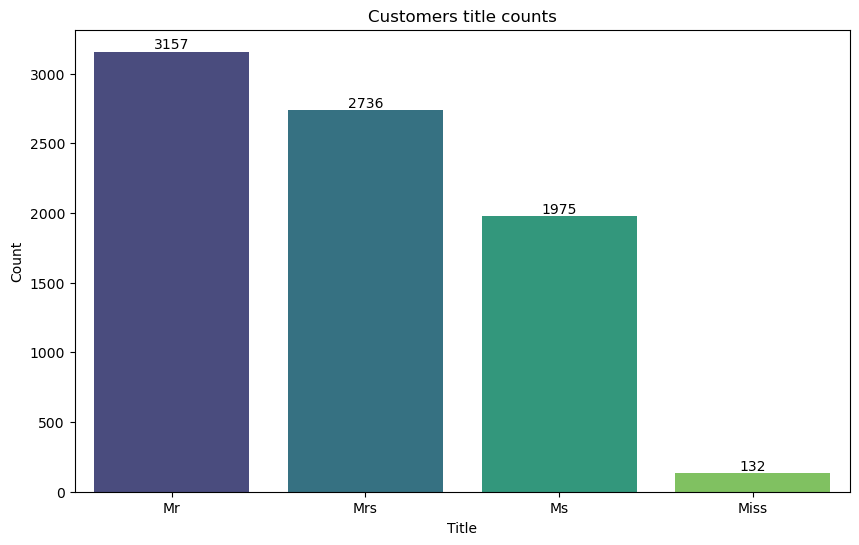

In [559]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data = customer_title_counts_df, x='Title', y='count', 
    palette='viridis',
    order=customer_title_counts_df.sort_values(by='count', ascending=False).Title,
);

ax.set(xlabel='Title', ylabel='Count', title='Customers title counts');
for i in ax.containers:
    ax.bar_label(i,)

## Utility functions

In [562]:
def average_buying_delay(row) -> int:
    """
    """
    c_df = orders_df[orders_df['Customer ID'] == row['Customer ID']]['Order Date'].reset_index()
    return c_df['Order Date'].diff().mean().days


def average_delivery_delay(row) -> int:
    c_df = orders_df[orders_df['Customer ID'] == row['Customer ID']][['Order Date', 'Dispatch Date']].reset_index()
    return (c_df['Dispatch Date'] - c_df['Order Date']).mean().days

def customer_total_expenses(cid) -> float:
    return orders_df[orders_df['Customer ID'] == cid]['total'].sum()

In [563]:
customers_df['expenses'] = customers_df['Customer ID'].apply(customer_total_expenses)
customers_df['Sex'] = customers_df.Title.map({'Mr': 'Male', 'Mrs': 'Female', 'Ms': 'Female', 'Miss': 'Female'})

## Total expenses by title

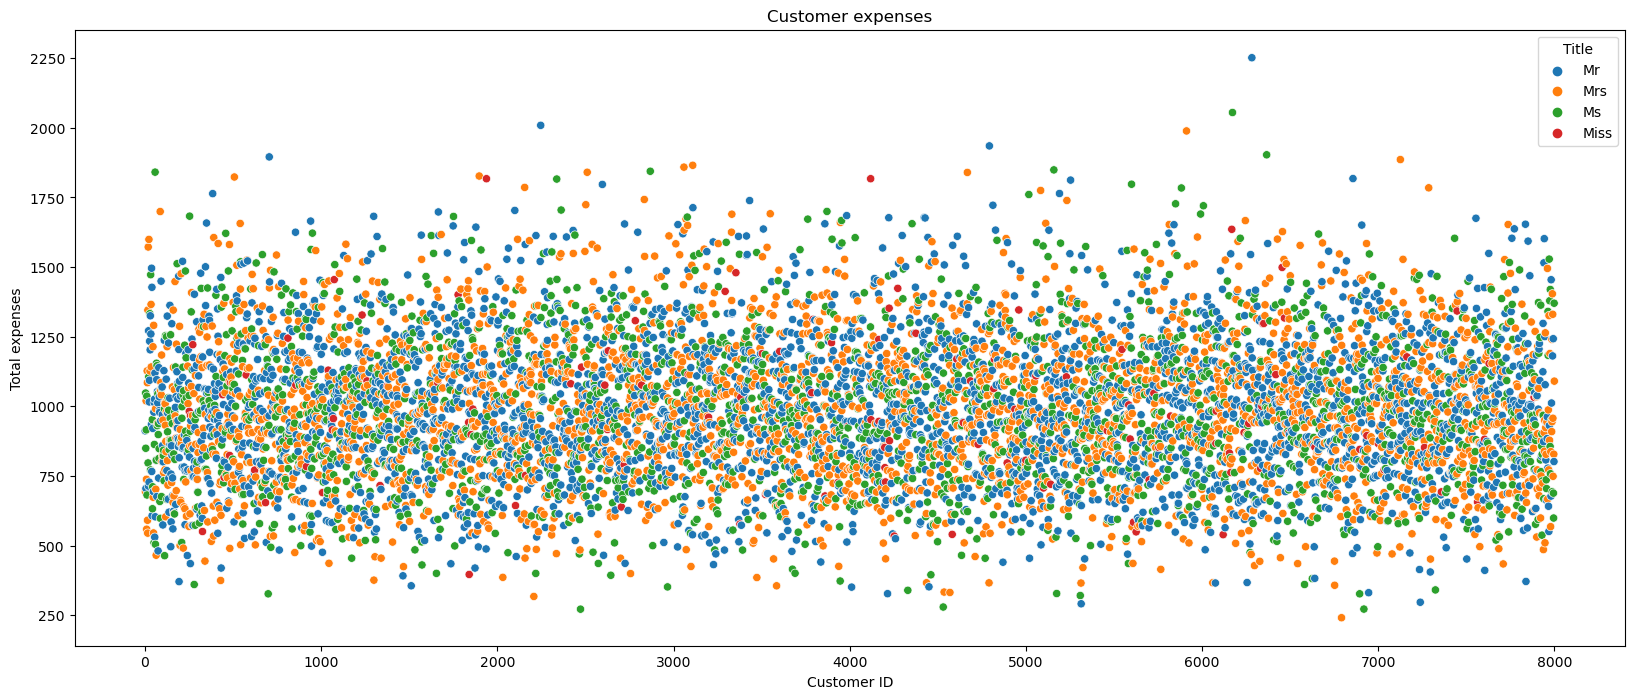

In [567]:
plt.figure(figsize=(20, 8))
ax = sns.scatterplot(data=customers_df, x='Customer ID', y='expenses', hue='Title');
ax.set(xlabel='Customer ID', ylabel='Total expenses', title='Customer expenses');

## Extracting useful data

In [240]:
customer_behaviour_df = orders_df.groupby('Customer ID').agg({'total': 'mean', 'Order No': 'count'}).reset_index()
customer_behaviour_df['max_expense'] = orders_df.groupby('Customer ID').agg({'total': 'max'}).reset_index()['total']
customer_behaviour_df['min_expense'] = orders_df.groupby('Customer ID').agg({'total': 'min'}).reset_index()['total']
customer_behaviour_df['avg_buy_delay'] = customer_behaviour_df.apply(average_buying_delay, axis=1)
customer_behaviour_df['avg_del_delay'] = customer_behaviour_df.apply(average_delivery_delay, axis=1)

In [ ]:
customer_behaviour_df.rename(
    columns={
        'total': 'avg_expense', 
        'Order No' : 'frequency', 
        'Customer ID': 'id'
    }, 
    inplace=True,
)

### Aggragated DataFrame head

In [460]:
customer_behaviour_df.head(10)

,id,avg_expense,frequency,max_expense,min_expense,avg_buy_delay,avg_del_delay
0,1,56.996875,16,139.99,34.10,132,10
1,2,49.556429,14,124.08,19.28,136,11
2,3,45.549565,23,139.27,19.17,86,8
3,4,44.703158,19,94.50,19.03,99,9
4,5,41.478824,17,109.45,19.21,96,10
5,6,50.982500,20,79.28,19.22,96,8
6,7,45.780000,20,109.61,19.24,96,11
7,8,52.708571,14,109.38,19.55,142,9
8,9,50.793636,11,94.29,19.79,174,6
9,10,51.828000,20,124.82,19.16,104,11


## Some columns distributions

### Purchase count

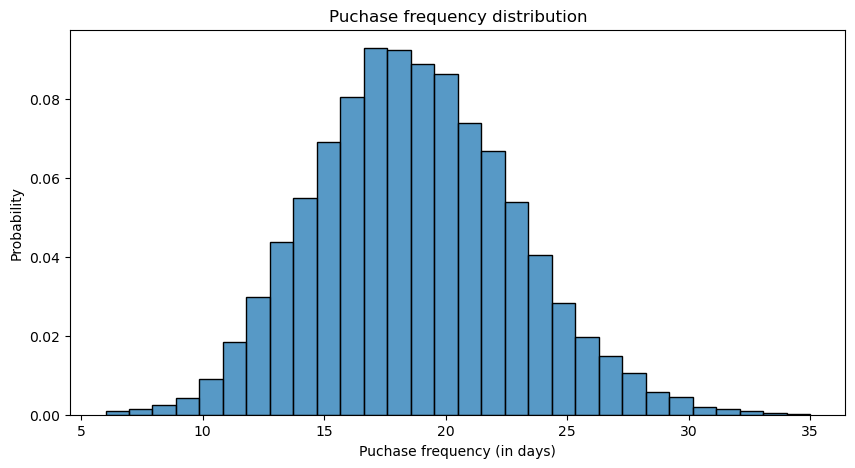

In [657]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(customer_behaviour_df, x='frequency', stat='probability', bins=30)

# x_axis = np.arange(customer_behaviour_df.frequency.min(), customer_behaviour_df.frequency.max(), 0.01) 
# # Estimating mean and standard deviation 
# mean = np.mean(x_axis) 
# sd = np.std(x_axis) 
# sns.lineplot(x=x_axis, y=stats.norm.pdf(x_axis, mean, sd), ax=ax) 

ax.set(xlabel='Puchase frequency (in days)', ylabel='Probability', title='Puchase frequency distribution');

### Delay between two consecutive purchases

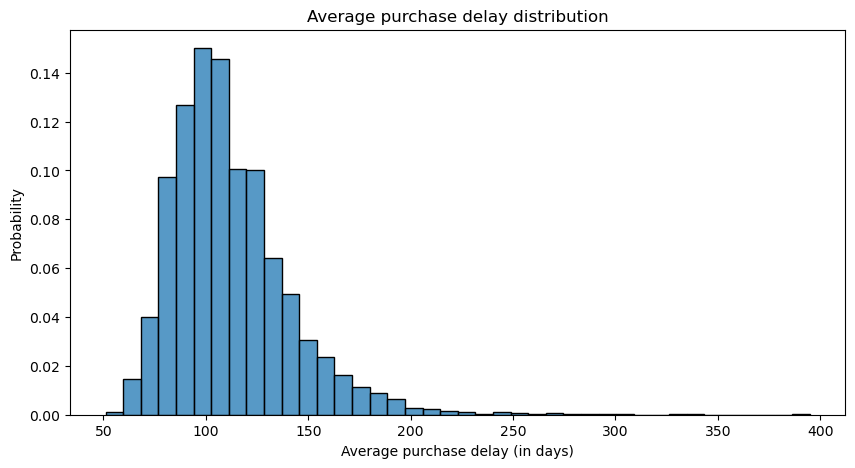

In [658]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(customer_behaviour_df, x='avg_buy_delay', stat='probability', bins=40)
ax.set(xlabel='Average purchase delay (in days)', ylabel='Probability', title='Average purchase delay distribution');

### Delivery delay

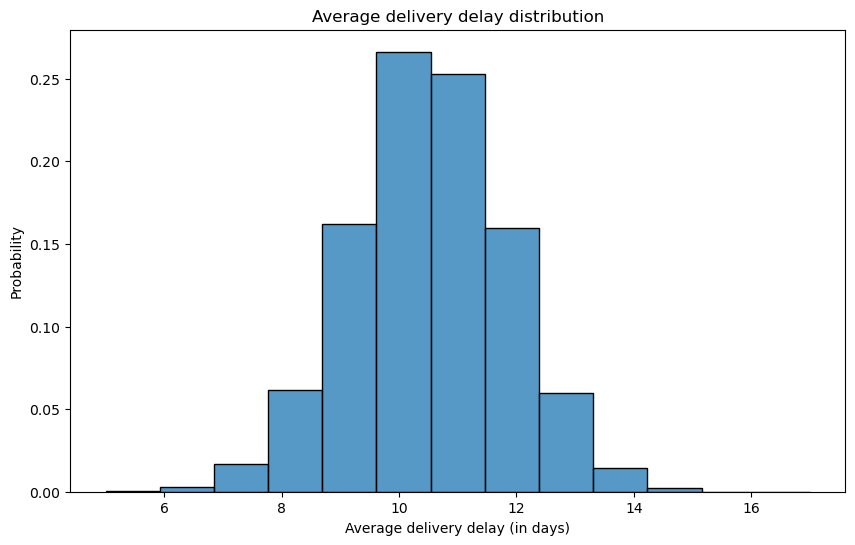

In [486]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(customer_behaviour_df, x='avg_del_delay', stat='probability', bins=13, kde=False)
ax.set(xlabel='Average delivery delay (in days)', ylabel='Probability', title='Average delivery delay distribution');

## Expense in purchases

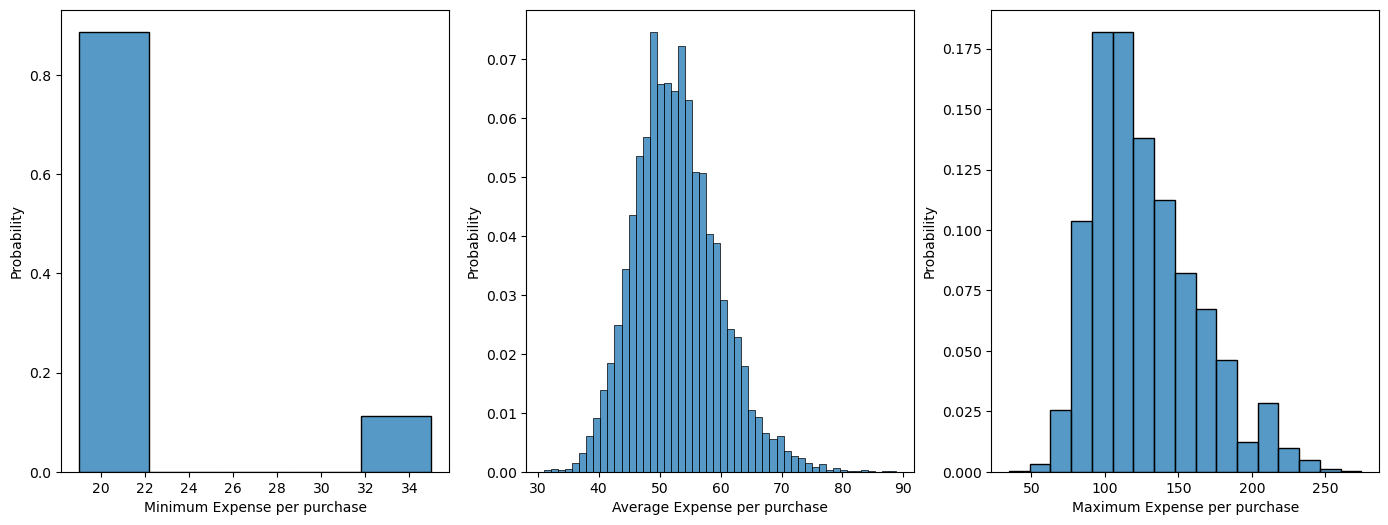

In [660]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 6))
sns.histplot(customer_behaviour_df, x='min_expense', stat='probability', kde=False, bins=5, label='Minimum Expense', ax=axs[0])
sns.histplot(customer_behaviour_df, x='avg_expense', stat='probability', kde=False, bins=50, label = 'Average Expense', ax=axs[1])
sns.histplot(customer_behaviour_df, x='max_expense', stat='probability', kde=False, bins=17, label='Maximum Expense', ax=axs[2])

axs[0].set(xlabel='Minimum Expense per purchase', ylabel='Probability');
axs[1].set(xlabel='Average Expense per purchase', ylabel='Probability');
axs[2].set(xlabel='Maximum Expense per purchase', ylabel='Probability');

## Clustering customers

### Finding the optimal number of clusters

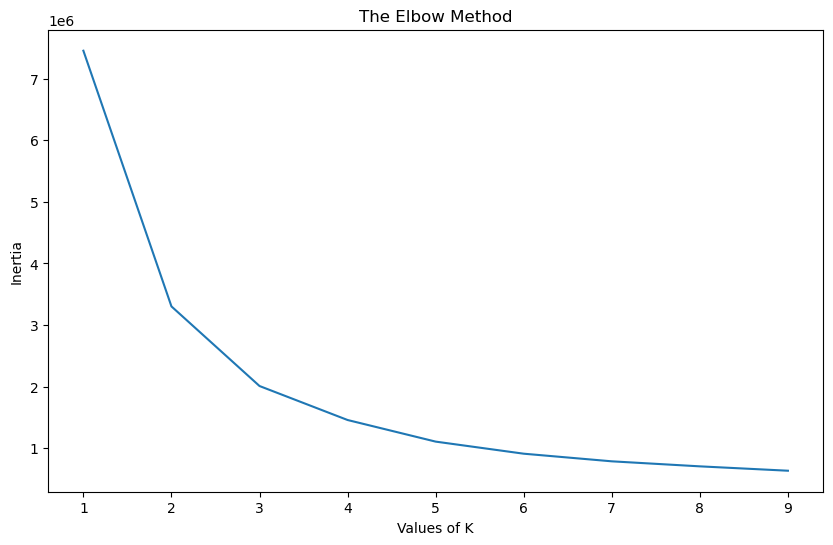

In [490]:
X_customer_behaviour_df = customer_behaviour_df.drop(['id', 'min_expense', 'max_expense'], axis=1)
X_customer_behaviour = X_customer_behaviour_df.values

inertias = []

K = range(1, 10)
 
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_customer_behaviour)
    kmeanModel.fit(X_customer_behaviour)
    inertias.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(x=K, y=inertias, markers='o')
ax.set(xlabel='Values of K', ylabel='Inertia', title='The Elbow Method');

### Performing the clustering

In [532]:
k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_customer_behaviour)
X_customer_behaviour_df['cluster'] = y_kmeans
customer_cluster_counts_df = X_customer_behaviour_df['cluster'].value_counts().reset_index(name='count')

### Customers per cluster count

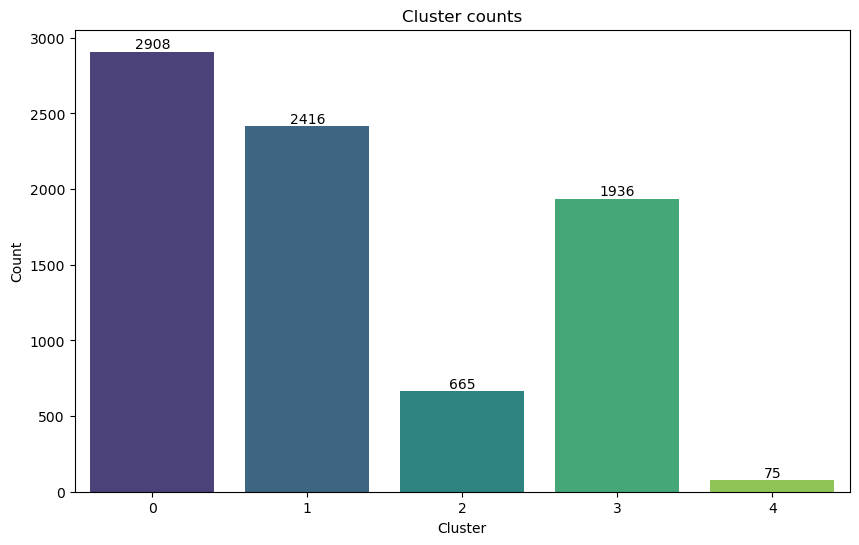

In [537]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data = customer_cluster_counts_df, x='cluster', y='count', 
    palette='viridis',
    # order=customer_cluster_counts_df.sort_values(by='count', ascending=False).cluster
);

ax.set(xlabel='Cluster', ylabel='Count', title='Cluster counts');

for i in ax.containers:
    ax.bar_label(i,)

### Customers behaviour per cluster

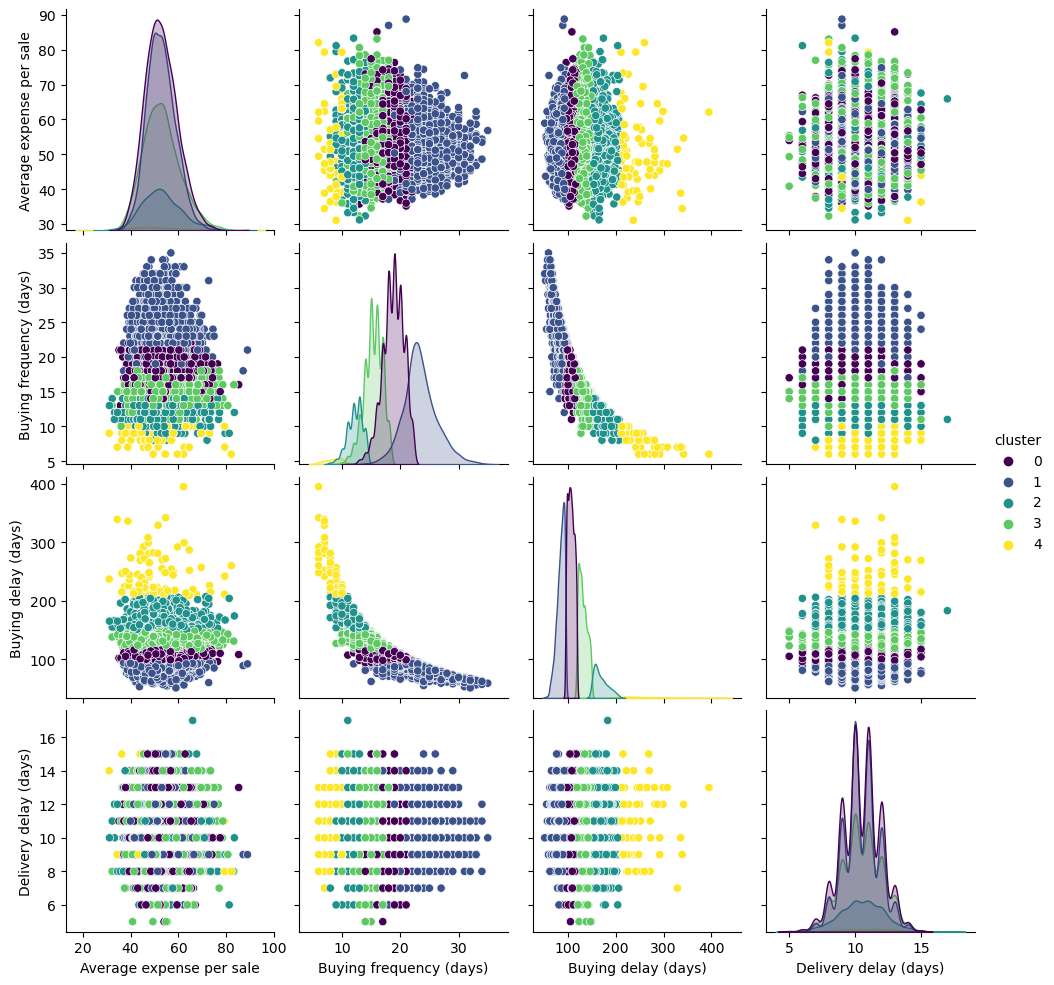

In [541]:
ax = sns.pairplot(X_customer_behaviour_df, hue='cluster', palette="viridis")

axs_labels = {
    'avg_expense': 'Average expense per sale', 
    'frequency': 'Buying frequency (days)', 
    'avg_buy_delay': 'Buying delay (days)',
    'avg_del_delay': 'Delivery delay (days)',
}

for i in range(len(axs_labels)):
    for j in range(len(axs_labels)):
        xlabel = ax.axes[i][j].get_xlabel()
        ylabel = ax.axes[i][j].get_ylabel()
        if xlabel in axs_labels.keys():
            ax.axes[i][j].set_xlabel(axs_labels[xlabel])
        if ylabel in axs_labels.keys():
            ax.axes[i][j].set_ylabel(axs_labels[ylabel])


# Employee performance analysis

## Utility functions

In [231]:
def unique_customers_count(eid):
    return len(orders_df[orders_df['Employee Code'] == eid]['Customer ID'].unique())

def average_cost_per_sale(eid):
    return orders_df[orders_df['Employee Code'] == eid]['total'].mean()

## Extracting useful data

In [234]:
employee_behaviour_df = orders_df.groupby(['Employee Code']).agg({'total': 'sum', 'Order No': 'count'}).reset_index()
employee_behaviour_df['unique_customers'] = employee_behaviour_df['Employee Code'].apply(unique_customers_count)
employee_behaviour_df['avg_sale'] = employee_behaviour_df['Employee Code'].apply(average_cost_per_sale)

In [ ]:
employee_behaviour_df.rename(
    columns={
        'total': 'total_sales', 
        'Order No' : 'frequency', 
        'Employee Code': 'id'
    }, 
    inplace=True,
)

## Aggregate DataFrame head

In [523]:
employee_behaviour_df.head(10)

,id,total_sales,frequency,unique_customers,avg_sale
0,1,39316.49,752,733,52.282566
1,2,16080.82,358,350,44.918492
2,3,159298.79,2596,2208,61.363170
3,4,15321.57,343,339,44.669300
4,5,37377.45,714,697,52.349370
5,6,41282.54,796,779,51.862487
6,7,39254.06,756,741,51.923360
7,8,37602.41,728,707,51.651662
8,9,39961.84,764,737,52.306073
9,10,41124.62,750,721,54.832827


## Some columns distributions

### Sales count

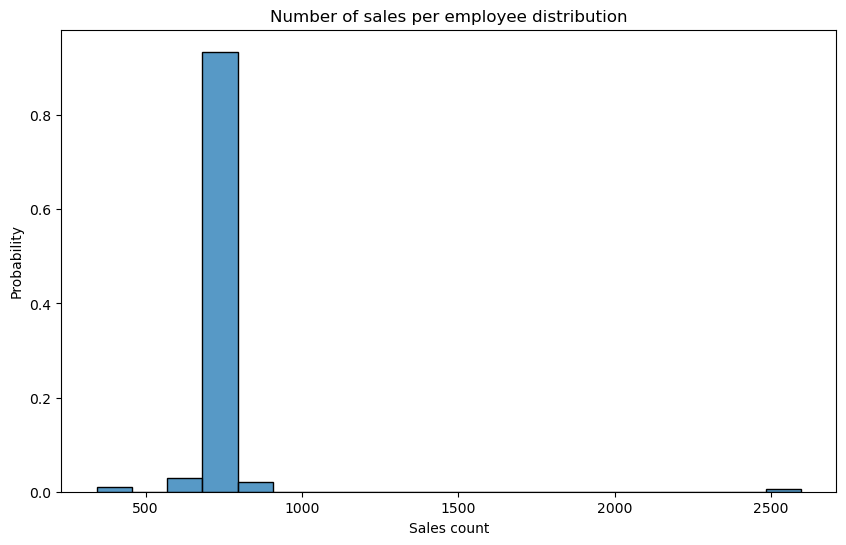

In [526]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(employee_behaviour_df, x='frequency', stat='probability', bins=20)
ax.set(xlabel='Sales count', ylabel='Probability', title='Number of sales per employee distribution');

### Total sales

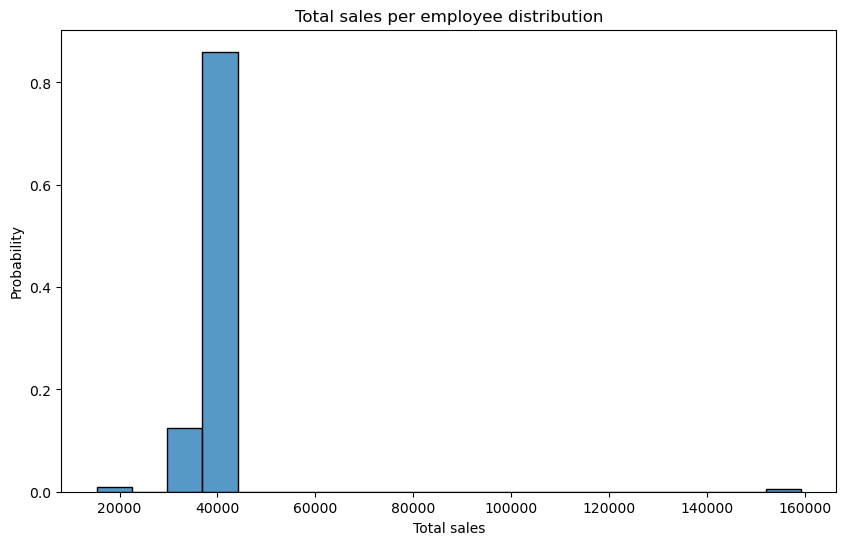

In [528]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(employee_behaviour_df, x='total_sales', stat='probability', bins=20)
ax.set(xlabel='Total sales', ylabel='Probability', title='Total sales per employee distribution');

### Unique customers

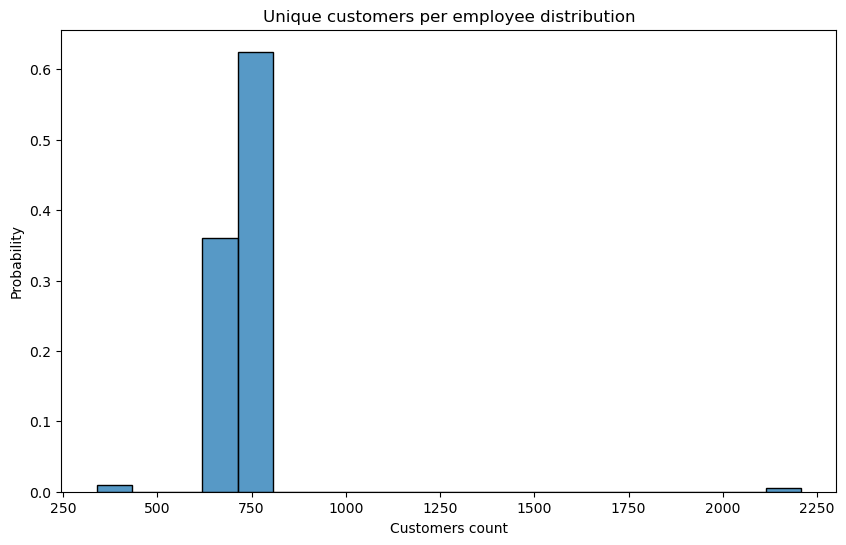

In [530]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(employee_behaviour_df, x='unique_customers', stat='probability', bins=20)
ax.set(xlabel='Customers count', ylabel='Probability', title='Unique customers per employee distribution');

### Average sale

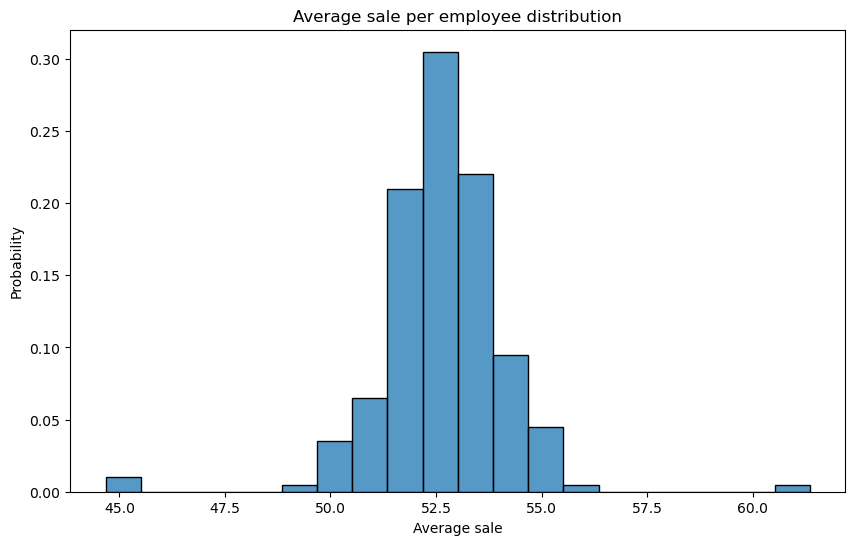

In [529]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(employee_behaviour_df, x='avg_sale', stat='probability', bins=20)
ax.set(xlabel='Average sale', ylabel='Probability', title='Average sale per employee distribution');

## Clustering the employees

### Finding the optimal number of clusters

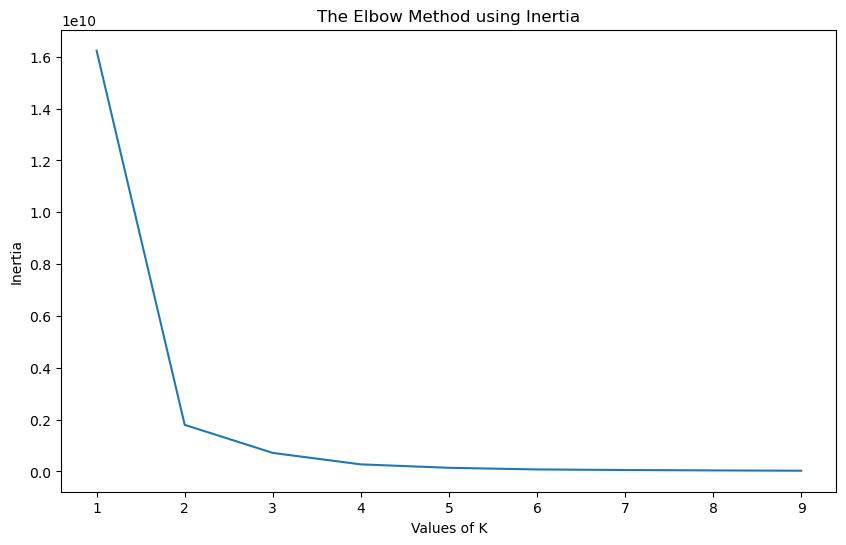

In [659]:
X_employee_behaviour_df = employee_behaviour_df.drop(['id', 'unique_customers'], axis=1)
X_employee_behaviour = X_employee_behaviour_df.values

inertias = []

K = range(1, 10)
 
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_employee_behaviour)
    kmeanModel.fit(X_employee_behaviour)
    inertias.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=K, y=inertias, markers='o')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Performing the clustering

In [534]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_employee_behaviour)
X_employee_behaviour_df['cluster'] = y_kmeans
X_employee_behaviour_df['cluster'].value_counts()
employee_cluster_counts_df = X_employee_behaviour_df['cluster'].value_counts().reset_index(name='count')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')

### Employees per cluster

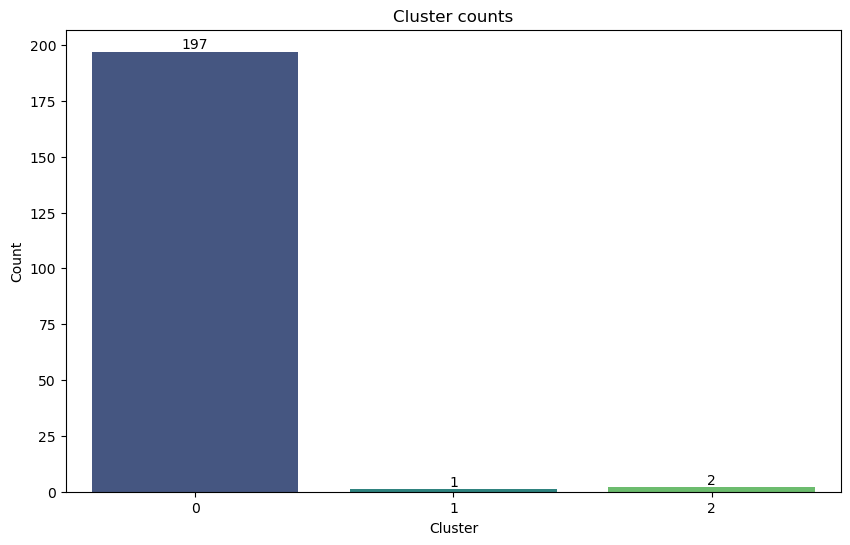

In [536]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data = employee_cluster_counts_df, x='cluster', y='count', 
    palette='viridis',
    # order=employee_cluster_counts_df.sort_values(by='count', ascending=False).cluster
);
ax.set(xlabel='Cluster', ylabel='Count', title='Cluster counts');
for i in ax.containers:
    ax.bar_label(i,)

### Employees behaviour per cluster

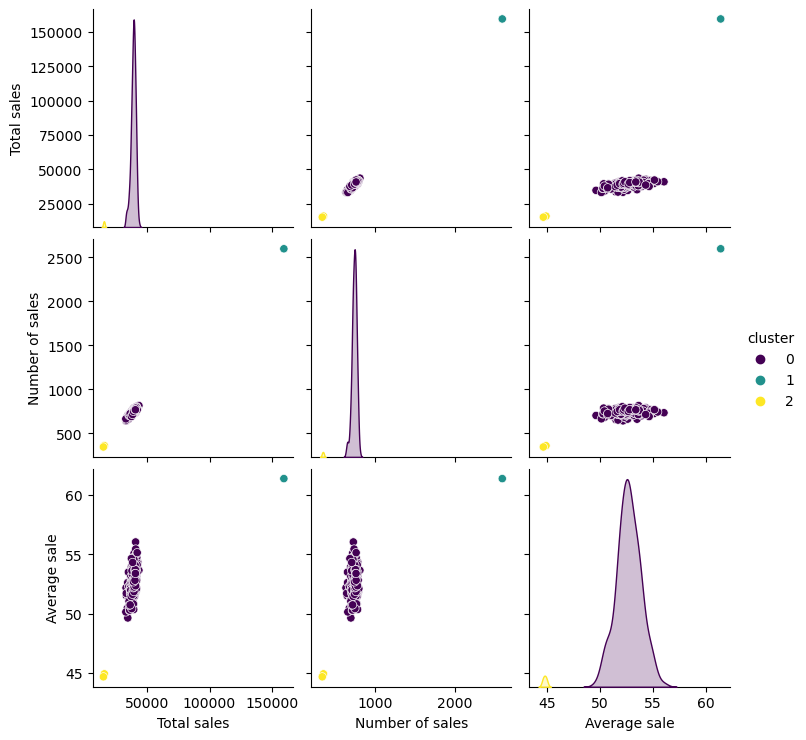

In [540]:
ax = sns.pairplot(X_employee_behaviour_df, hue='cluster', palette="viridis")

axs_labels = {
    'total_sales': 'Total sales', 
    'frequency': 'Number of sales', 
    'avg_sale': 'Average sale',
}

for i in range(len(axs_labels)):
    for j in range(len(axs_labels)):
        xlabel = ax.axes[i][j].get_xlabel()
        ylabel = ax.axes[i][j].get_ylabel()
        if xlabel in axs_labels.keys():
            ax.axes[i][j].set_xlabel(axs_labels[xlabel])
        if ylabel in axs_labels.keys():
            ax.axes[i][j].set_ylabel(axs_labels[ylabel])


# Orders info & Items analysis

In [286]:
order_details_df['u_cost'] = order_details_df['Item No'].apply(lambda x: items_df.loc[x, 'Cost Price'])
order_details_df['u_nominal'] = order_details_df['Item No'].apply(lambda x: items_df.loc[x, 'Nominal Sale Price'])
order_details_df['cost'] = order_details_df['u_cost'] * order_details_df['Quantity']
order_details_df['nominal'] = order_details_df['u_nominal'] * order_details_df['Quantity']

In [338]:
orders_agg_df = order_details_df.groupby(['Order No']).agg({'cost': 'sum', 'nominal': 'sum'}).reset_index()
items_agg_df = order_details_df.groupby(['Item No']).agg({'cost': 'count'}).reset_index()
items_agg_df.rename(columns={'cost': 'frequency'}, inplace=True)

## Missing orders

In [339]:
missing_orders = np.array([o for o in orders_df['Order No'].values if o not in orders_agg_df['Order No'].values])
missing_orders

array([  237,   243,  2179,  3169,  3864,  6399,  6415,  9482,  9879,
       14404, 14999, 15169, 17805, 20540, 21535, 23117, 25295, 38404,
       40080, 46425, 84227])

## Never sold items

In [340]:
never_sold_items = np.array([i for i in items_df['Item No'].values if i not in items_agg_df['Item No'].values])
never_sold_items

array([], dtype=float64)

## Item Sales frequency

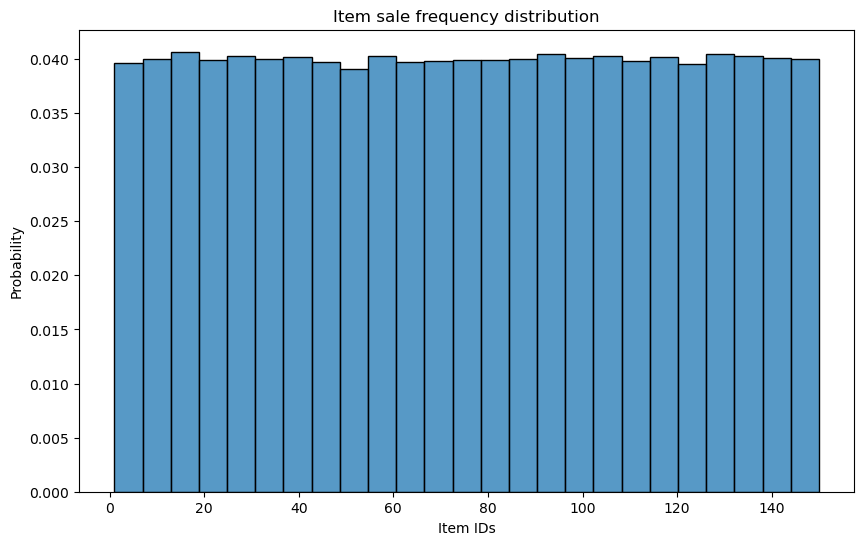

In [543]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=order_details_df, x='Item No', bins=25, stat='probability')
ax.set(xlabel='Item IDs', ylabel='Probability', title='Item sale frequency distribution');

## Cost vs Nominal sale prices

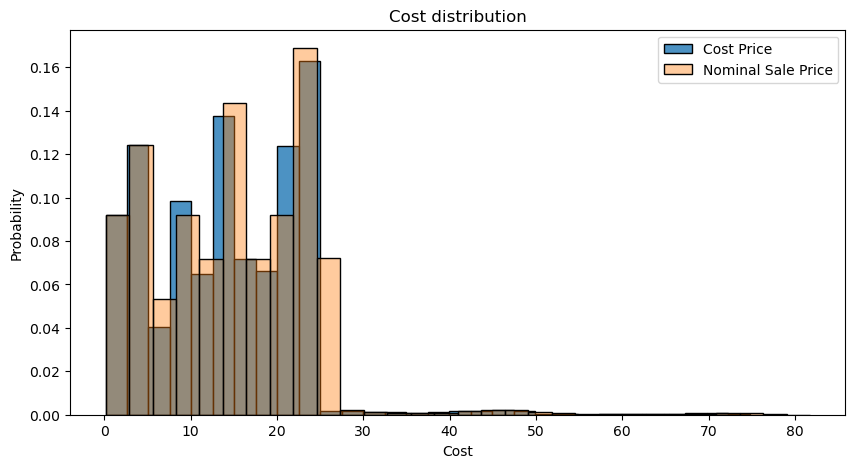

In [568]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=order_details_df, x='cost', bins=30, stat='probability', alpha=.8, label="Cost Price")
sns.histplot(data=order_details_df, x='nominal', bins=30, stat='probability', alpha=.4, ax=ax, label="Nominal Sale Price")
ax.set(xlabel='Cost', ylabel='Probability', title='Cost distribution');
ax.legend();

# Outliers detection in the daily sales time series

In [603]:
daily_sales = daily_orders_df[['total', 'date']]

## Using the Inter Quartile Range (IQR)

In [585]:
q1 = daily_sales['total'].quantile(0.25)
q3 = daily_sales['total'].quantile(0.75)
iqr = q3 - q1

In [605]:
daily_sales['outlier'] = (daily_sales['total'] < (q1 - 1.5 * iqr)) | (daily_sales['total'] > (q3 + 1.5 * iqr))

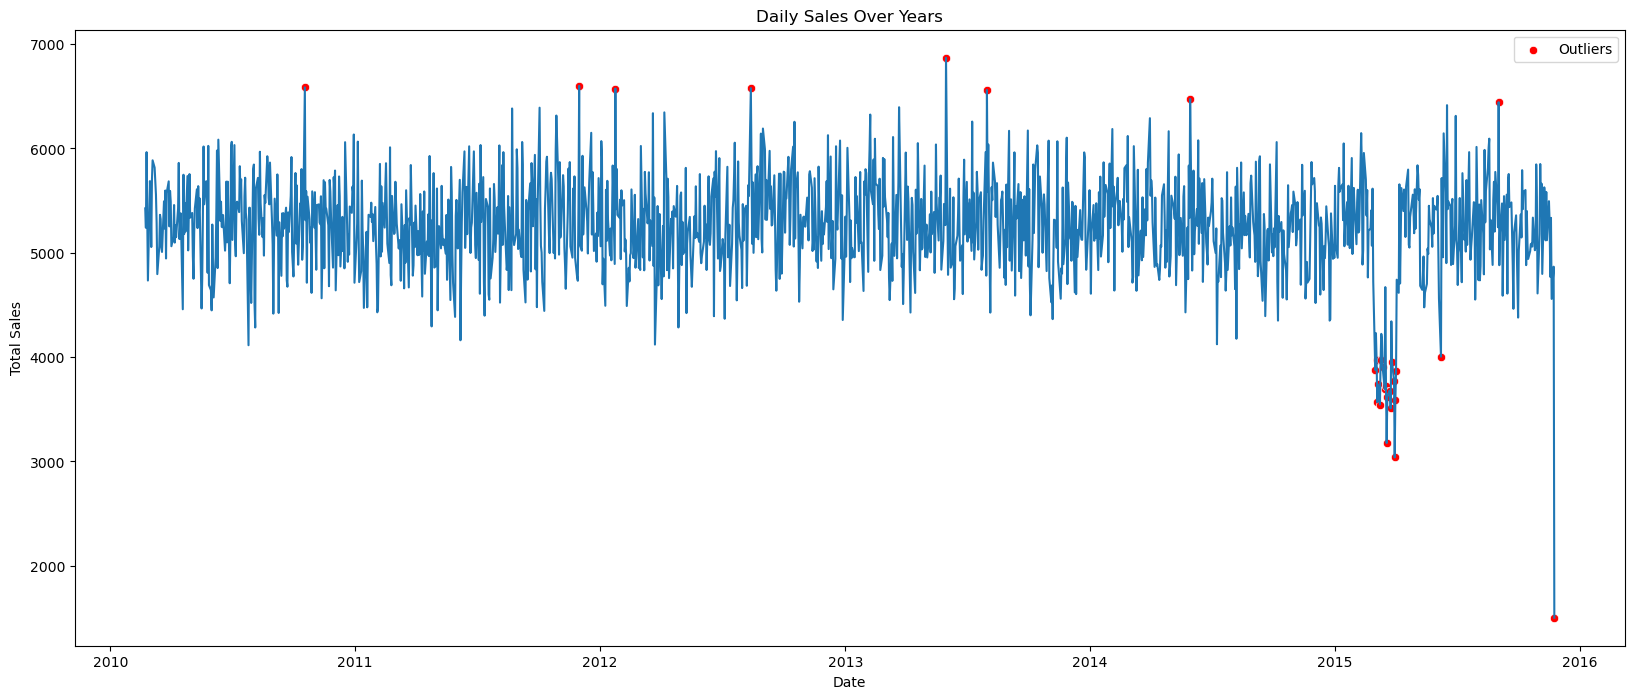

In [609]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=daily_sales, x='date', y='total', linestyle='-')
ax = sns.scatterplot(data=daily_sales[daily_sales["outlier"]], x='date', y='total', color='red', label='Outliers')
ax.set(ylabel='Total Sales', xlabel='Date', title='Daily Sales Over Years');
ax.legend();

##  Using the generalized Extreme Studentized Deviate (ESD)

Assuming that normal values follow an approximately normal distribution.

In [619]:
df = daily_sales.drop('outlier', axis=1)
df.set_index('date', inplace=True)
s_train = validate_series(df).reset_index()
s_train.set_index('date', inplace=True)

In [635]:
esd_ad = GeneralizedESDTestAD(alpha=0.3)
anomalies = esd_ad.fit_detect(s_train)
daily_sales['outlier'] = anomalies['total'].values

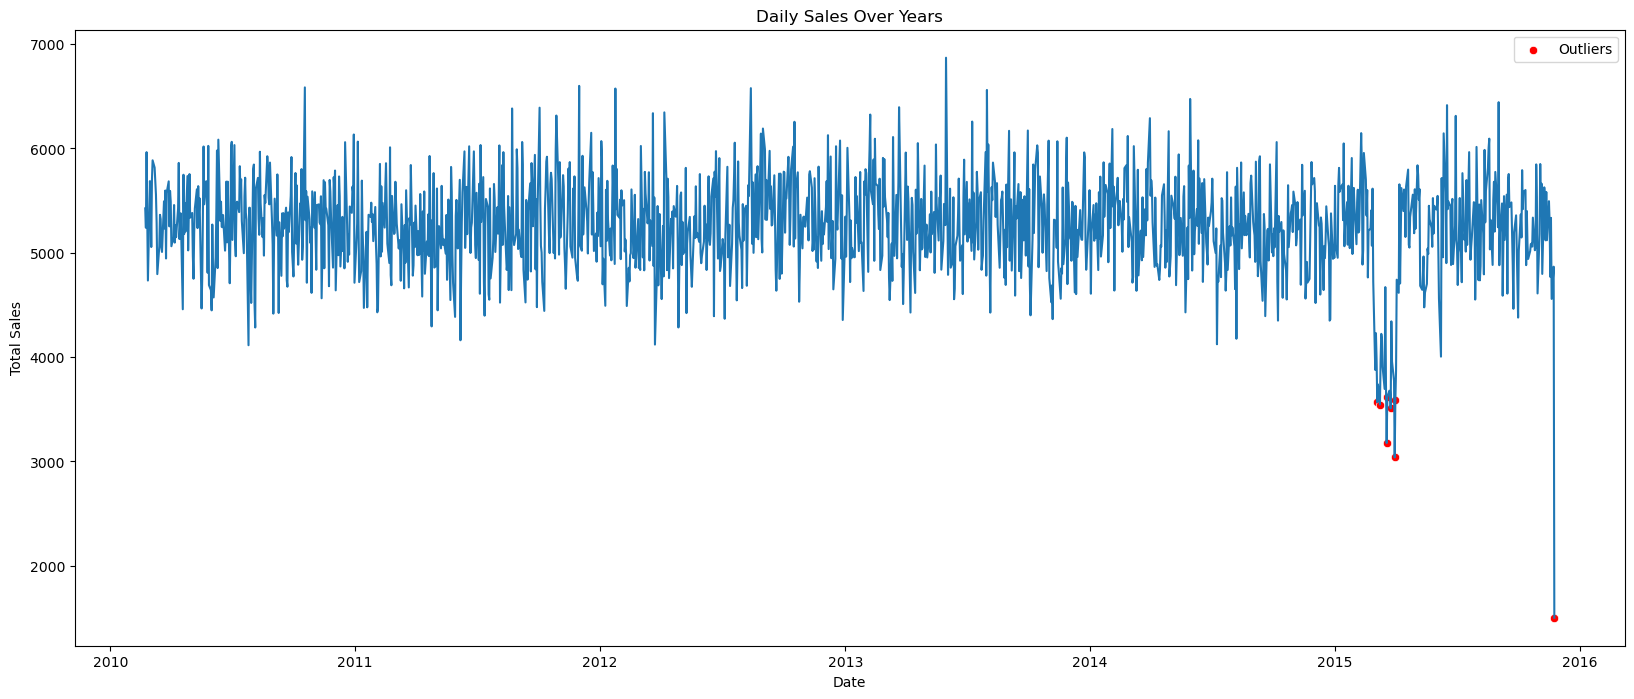

In [636]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=daily_sales, x='date', y='total', linestyle='-')
ax = sns.scatterplot(data=daily_sales[daily_sales["outlier"]], x='date', y='total', color='red', label='Outliers')
ax.set(ylabel='Total Sales', xlabel='Date', title='Daily Sales Over Years');
ax.legend();

In [ ]:
# viz.plot(s_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

## Tracking brutal changes both negatively and positively

In [653]:
c = 1.5
persist_ad = PersistAD(c=c, side='positive')
positive_anomalies = persist_ad.fit_detect(s_train)

persist_ad = PersistAD(c=c, side='negative')
negative_anomalies = persist_ad.fit_detect(s_train)

In [654]:
daily_sales['outlier'] = np.logical_or(positive_anomalies['total'].values, negative_anomalies['total'].values)
daily_sales['outlier'] = daily_sales['outlier'].fillna(False)

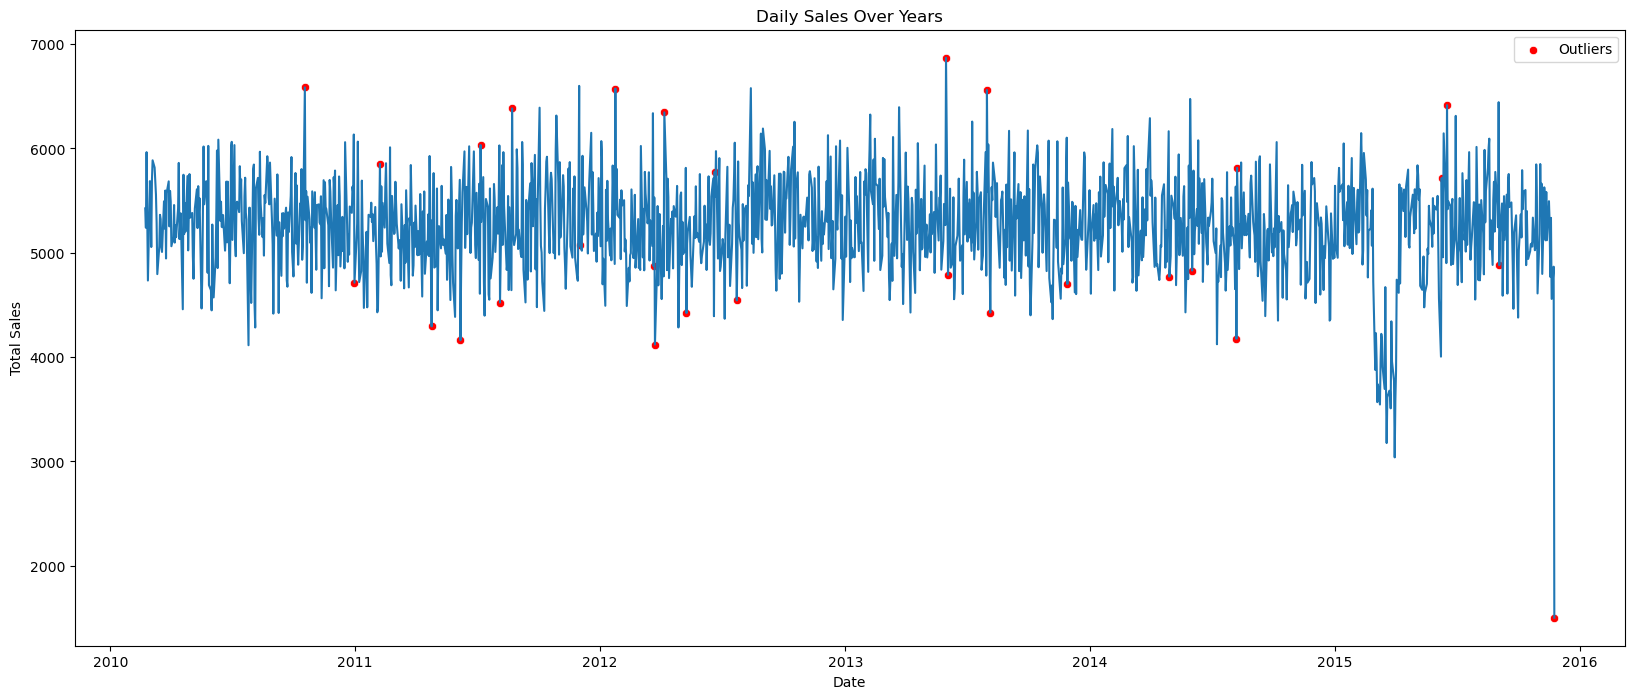

In [655]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=daily_sales, x='date', y='total', linestyle='-')
ax = sns.scatterplot(data=daily_sales[daily_sales["outlier"]], x='date', y='total', color='red', label='Outliers')
ax.set(ylabel='Total Sales', xlabel='Date', title='Daily Sales Over Years');
ax.legend();

In [ ]:
# viz.plot(s_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red');